In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import psycopg2
from sklearn.model_selection import train_test_split
import warnings
import random

# Prepare clustering data

## 1. Extract week level demand data (SoldQty) from the database

Level of data expected: Week Number x Brand

In [89]:
try:
    # Connect to your PostgreSQL database
    conn = psycopg2.connect(
        dbname="",
        user="",
        password="",
        host="",
        port=""
    )
    print("Connection successful!")

    cur = conn.cursor()

    # Fetch data
    query='''
SELECT
	DATE_PART('week', S."SalesDate") AS "WeekNumber",
    PP."Brand",
    P."ProductSKU",
    P."VolumeSize",
    P."AlcoholType",
    P."ABV",
    P."FlavorProfile",
    PP."SalesPrice" AS "SellingPricePerQty",
    sum(S."SalesQuantity") as "TotalSalesQtyWeek"
FROM 
	analytical_tables."Sales_History" AS S 
LEFT JOIN 
	analytical_tables."Product_Purchase_Sale_Prices" AS PP
ON 
	S."Brand" = PP."Brand"
LEFT JOIN
	analytical_tables."Product_Info" AS P 
ON 
	PP."ProductSKU" = P."ProductSKU"
WHERE  
	S."StoreID" = '51'
GROUP BY 
	1,2,3,4,5,6,7,8
        '''
    cur.execute(query)

    
    rows = cur.fetchall() # Fetch the data
    col_names = [desc[0] for desc in cur.description] # Fetch column names

    # Close the cursor and connection
    cur.close()
    conn.close()

    # Convert to dataframe
    df = pd.DataFrame(rows, columns=col_names)  
    print("Data Shape:", df.shape)
    display(df.sample(3))

except psycopg2.Error as e:
    print("Error connecting to PostgreSQL database:", e)

Connection successful!
Data Shape: (62566, 9)


,WeekNumber,Brand,ProductSKU,VolumeSize,AlcoholType,ABV,FlavorProfile,SellingPricePerQty,TotalSalesQtyWeek
45180,40.0,12154,4111,750.0,Others,14.5,Fruity,14.99,1
38122,34.0,15619,1981,750.0,Wine,9.0,Fruity,5.99,3
38676,34.0,4224,5824,750.0,Rum,40.0,Sweet,14.99,1


In [3]:
df.isna().any().any()

False

## Check correlation to identify the column that contributes the most

Why? To decide if WeekNum, product info and sales price is sufficient to predict the label.
* If not, include last N week sales average
* If not, include ProductSKU or Brand

In [90]:
df.dtypes

WeekNumber            float64
Brand                  object
ProductSKU             object
VolumeSize            float64
AlcoholType            object
ABV                   float64
FlavorProfile          object
SellingPricePerQty    float64
TotalSalesQtyWeek       int64
dtype: object

In [91]:
df.describe()

,WeekNumber,VolumeSize,ABV,SellingPricePerQty,TotalSalesQtyWeek
count,62566.000000,62566.000000,62566.000000,62566.000000,62566.000000
mean,27.551689,990.041748,26.776549,15.855294,5.244957
std,15.291596,670.633437,13.559343,18.321990,9.438636
min,1.000000,50.000000,0.000000,0.490000,1.000000
25%,14.000000,750.000000,13.500000,8.990000,1.000000
50%,28.000000,750.000000,28.000000,12.990000,2.000000
75%,41.000000,1000.000000,40.000000,18.990000,5.000000
max,53.000000,5000.000000,75.500000,2999.990000,232.000000


In [92]:
# Remove Outlier- Remove data over 98 percentile of the data
df_NoOutlier= df[df['TotalSalesQtyWeek']<df['TotalSalesQtyWeek'].quantile(0.98)]
df_NoOutlier.describe()

,WeekNumber,VolumeSize,ABV,SellingPricePerQty,TotalSalesQtyWeek
count,61312.000000,61312.000000,61312.000000,61312.000000,61312.000000
mean,27.516604,994.162676,26.622200,16.022951,4.190419
std,15.295949,673.628907,13.556011,18.417291,4.681150
min,1.000000,50.000000,0.000000,0.490000,1.000000
25%,14.000000,750.000000,13.500000,8.990000,1.000000
50%,28.000000,750.000000,25.000000,12.990000,2.000000
75%,41.000000,1000.000000,40.000000,18.990000,5.000000
max,53.000000,5000.000000,75.500000,2999.990000,30.000000


In [93]:
df_NoOutlier.isna().any().any()

False

In [94]:
df_NoOutlier.head()

,WeekNumber,Brand,ProductSKU,VolumeSize,AlcoholType,ABV,FlavorProfile,SellingPricePerQty,TotalSalesQtyWeek
0,1.0,1001,1701,200.0,Others,19.428218,Others,5.99,2
1,1.0,10058,5046,750.0,Others,15.000000,Others,13.99,2
2,1.0,10062,11234,750.0,Wine,13.000000,Others,8.99,1
3,1.0,10227,4803,750.0,Wine,13.500000,Others,9.99,7
4,1.0,10239,2739,750.0,Wine,13.500000,Fruity,14.99,5


In [95]:
def Define_Demand_Ctg(demand):
    if(demand < 5): return "Low"
    #elif(demand < 5): return "Medium"
    else: return "High"

df_NoOutlier['Demand_Ctg']= df_NoOutlier['TotalSalesQtyWeek'].apply(Define_Demand_Ctg)
df_NoOutlier.groupby(['Demand_Ctg']).agg({'SellingPricePerQty': ['mean','min','max','count']}).reset_index()


C:\Users\admin\AppData\Local\Temp\ipykernel_6696\3938735961.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NoOutlier['Demand_Ctg']= df_NoOutlier['TotalSalesQtyWeek'].apply(Define_Demand_Ctg)


Demand_Ctg SellingPricePerQty                      
                           mean   min      max  count
0       High          12.761943  0.49   189.99  17275
1        Low          17.302191  0.49  2999.99  44037

In [96]:
df_NoOutlier.sample(5)

,WeekNumber,Brand,ProductSKU,VolumeSize,AlcoholType,ABV,FlavorProfile,SellingPricePerQty,TotalSalesQtyWeek,Demand_Ctg
36633,32.0,6855,8198,375.0,Others,45.0,Sweet,18.99,2,Low
21521,20.0,1637,5288,1750.0,Others,40.0,Others,11.49,1,Low
42076,37.0,3486,11097,1000.0,Gin,47.3,Herbal,12.99,1,Low
55425,48.0,3102,10620,1750.0,Vodka,0.0,Fruity,17.99,24,High
22166,20.0,4683,6127,1000.0,Others,40.0,Others,3.79,6,High


In [97]:
df_NoOutlier[selected_columns_for_clustering + Label].sample(5)

,WeekNumber,VolumeSize,AlcoholType,ABV,FlavorProfile,SellingPricePerQty,Demand_Ctg
41959,37.0,750.0,Wine,14.0,Fruity,34.99,Low
8402,8.0,750.0,Vodka,35.0,Fruity,15.99,High
43739,38.0,750.0,Others,17.0,Others,15.99,High
34684,31.0,50.0,Whiskey,35.0,Others,22.99,High
34965,31.0,375.0,Vodka,40.0,Other,1.49,Low


## 2. Apply Decision Tree after splitting the data.

### One Hot Encoding and Train Test Spllit

In [98]:
selected_columns_for_clustering= ['WeekNumber','VolumeSize','AlcoholType','ABV','FlavorProfile','SellingPricePerQty']
Categorical_Columns_For_OneHot= ['AlcoholType','FlavorProfile']
Label= ['Demand_Ctg']

df_encoded= df_NoOutlier[selected_columns_for_clustering + Label]


df_encoded = pd.get_dummies(df_encoded,columns = Categorical_Columns_For_OneHot, dtype=int)
print("Is Null?",df_encoded.isna().any().any())

X = df_encoded.drop(columns= Label)
y= df_encoded[Label]
print("X and Y Size After One Hot Encoding:")
print(X.shape)
print(y.shape)

print("X_train, X_test, y_train, y_test Size:")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=77)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
print("Training Y split:")
display(y_train[Label].value_counts().reset_index())
print("Testing Y split:")
y_test[Label].value_counts().reset_index()

Is Null? False
X and Y Size After One Hot Encoding:
(61312, 23)
(61312, 1)
X_train, X_test, y_train, y_test Size:
(41079, 23) (20233, 23) (41079, 1) (20233, 1)
Training Y split:


,Demand_Ctg,count
0,Low,29457
1,High,11622


Testing Y split:


,Demand_Ctg,count
0,Low,14580
1,High,5653


In [99]:
X_train.to_csv("X_Train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

In [87]:
X_test.sample(5)

,WeekNumber,VolumeSize,ABV,SellingPricePerQty,AlcoholType_Beer,AlcoholType_Gin,AlcoholType_Liqueurs,AlcoholType_Others,AlcoholType_Rum,AlcoholType_Tequila,...,FlavorProfile_Bitter,FlavorProfile_Floral,FlavorProfile_Fruity,FlavorProfile_Herbal,FlavorProfile_Other,FlavorProfile_Others,FlavorProfile_Savory,FlavorProfile_Sour,FlavorProfile_Spicy,FlavorProfile_Sweet
47622,42.0,1500.0,7.5,9.99,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
48301,42.0,750.0,14.5,16.99,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
16186,15.0,750.0,35.0,25.99,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
32903,29.0,750.0,40.0,11.99,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
57933,50.0,375.0,40.0,59.99,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [88]:
y_test.sample(5)

,Demand_Ctg
20142,Low
36904,Low
49848,Low
41858,Low
60156,High


# Decision Tree

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
#import graphviz 
from sklearn.metrics import confusion_matrix

In [48]:
model=DecisionTreeClassifier(criterion='entropy', ##"entropy" or "gini"
                            splitter='best',  ## or "random" or "best"
                            #max_depth=None, 
                            #min_samples_split=20, 
                            #min_samples_leaf=1, 
                            #min_weight_fraction_leaf=0.0, 
                            #max_features=None, 
                            #random_state=None, 
                            #max_leaf_nodes=None, 
                            #min_impurity_decrease=0.0, 
                            #class_weight=None
                            )

model.fit(X_train, y_train)
#tree.plot_tree(model)

DecisionTreeClassifier(criterion='entropy')

[Text(0.3151927111246446, 0.9886363636363636, 'x[3] <= 2.39\nentropy = 0.859\nsamples = 41079\nvalue = [11622.0, 29457.0]'),
 Text(0.043803028416708446, 0.9659090909090909, 'x[3] <= 1.74\nentropy = 0.905\nsamples = 2376\nvalue = [1614, 762]'),
 Text(0.022015110748923553, 0.9431818181818182, 'x[2] <= 5.0\nentropy = 0.946\nsamples = 1578\nvalue = [1004, 574]'),
 Text(0.0025296565233781836, 0.9204545454545454, 'x[0] <= 38.0\nentropy = 0.923\nsamples = 71\nvalue = [24, 47]'),
 Text(0.0018461560142760004, 0.8977272727272727, 'x[0] <= 23.0\nentropy = 0.852\nsamples = 54\nvalue = [15, 39]'),
 Text(0.001437464988214901, 0.875, 'x[0] <= 15.0\nentropy = 0.934\nsamples = 40\nvalue = [14, 26]'),
 Text(0.0009583099921432674, 0.8522727272727273, 'x[0] <= 2.5\nentropy = 0.797\nsamples = 29\nvalue = [7, 22]'),
 Text(0.0005637117600842749, 0.8295454545454546, 'x[15] <= 0.5\nentropy = 0.971\nsamples = 5\nvalue = [3, 2]'),
 Text(0.00045096940806741993, 0.8068181818181818, 'x[1] <= 400.0\nentropy = 1.0\ns

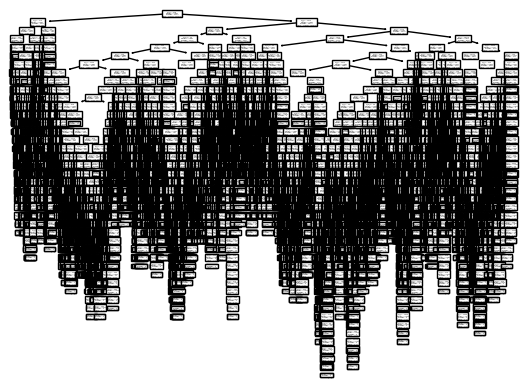

In [57]:
tree.plot_tree(model)

In [51]:
# Print feature importances along with their names
feature_names= X_test.columns

# Create a DataFrame with feature names and their importance values
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)

print("Feature importance sorted in descending order:")
feature_importance_df

Feature importance sorted in descending order:


,Feature,Importance
0,WeekNumber,0.461452
3,SellingPricePerQty,0.199008
2,ABV,0.123668
1,VolumeSize,0.059455
7,AlcoholType_Others,0.022868
18,FlavorProfile_Others,0.019184
15,FlavorProfile_Fruity,0.016294
22,FlavorProfile_Sweet,0.013128
12,AlcoholType_Wine,0.010946
10,AlcoholType_Vodka,0.010728


In [52]:
y_pred= model.predict(X_test)

Evaluation

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        High       0.53      0.57      0.55      5653
         Low       0.83      0.80      0.82     14580

    accuracy                           0.74     20233
   macro avg       0.68      0.69      0.68     20233
weighted avg       0.74      0.74      0.74     20233



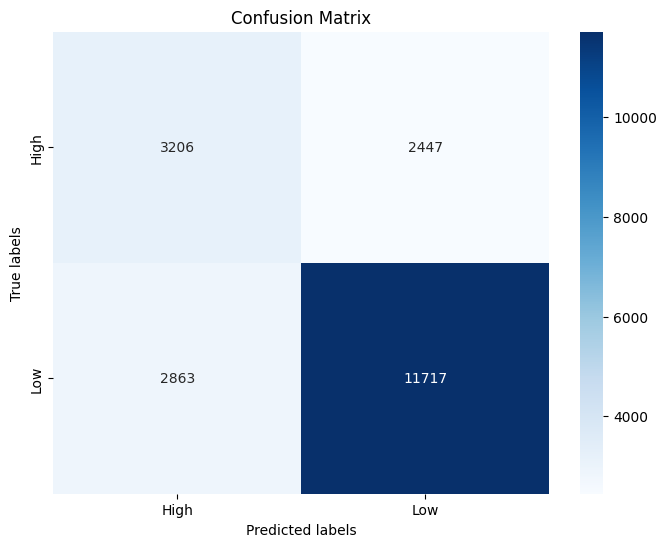

In [55]:
# Compute confusion matrix
import seaborn as sns 
import matplotlib.pyplot as plt 

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=y_test.Demand_Ctg.unique(), yticklabels=y_test.Demand_Ctg.unique())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print accuracy and other scores
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.7376
Precision: 0.7437
Recall: 0.7376
F1-score: 0.7403


Plot

In [67]:
#!pip install graphviz
import graphviz
import os
os.environ["PATH"] += os.pathsep + "C:/Program Files (x86)/Graphviz-10.0.1-win64/bin/"

In [74]:
TREE_data = tree.export_graphviz(model, out_file=None,
                  feature_names=X_train.columns,
                  filled=True, 
                  rounded=True,  
                  special_characters=True) 
                                   
graph = graphviz.Source(TREE_data) 
graph.render("Tree_Record") 

'Tree_Record.pdf'

# Naive Bayes

In [58]:
from sklearn.naive_bayes import MultinomialNB

In [59]:
model_NB= MultinomialNB()
model_NB.fit(X_train, y_train)
y_pred_NB = model_NB.predict(X_test)

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


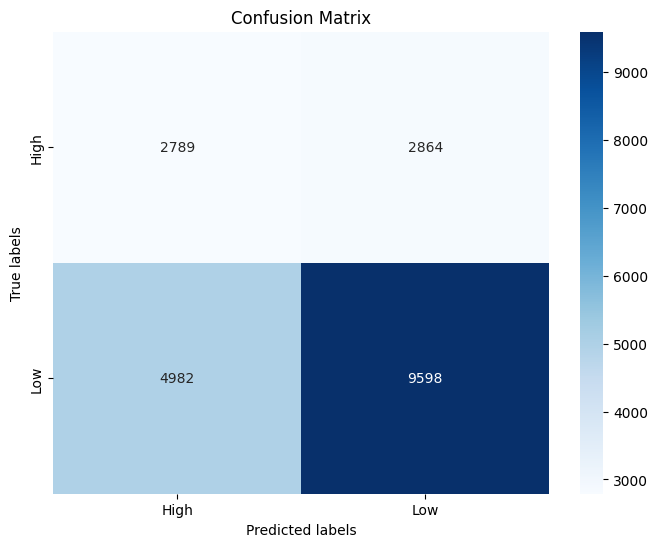

Accuracy: 0.6122
Precision: 0.6553
Recall: 0.6122
F1-score: 0.6276


In [61]:
cm = confusion_matrix(y_test, y_pred_NB)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=y_test.Demand_Ctg.unique(), yticklabels=y_test.Demand_Ctg.unique())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred_NB)
precision = precision_score(y_test, y_pred_NB, average='weighted')
recall = recall_score(y_test, y_pred_NB, average='weighted')
f1 = f1_score(y_test, y_pred_NB, average='weighted')

# Print accuracy and other scores
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

In [62]:
model_NB.get_params(deep=True)

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}

In [63]:
print(np.round(model_NB.predict_proba(X_test),2))

[[0.91 0.09]
 [0.02 0.98]
 [0.08 0.92]
 ...
 [0.99 0.01]
 [0.03 0.97]
 [0.05 0.95]]


In [64]:
X_train.head()

,WeekNumber,VolumeSize,ABV,SellingPricePerQty,AlcoholType_Beer,AlcoholType_Gin,AlcoholType_Liqueurs,AlcoholType_Others,AlcoholType_Rum,AlcoholType_Tequila,...,FlavorProfile_Bitter,FlavorProfile_Floral,FlavorProfile_Fruity,FlavorProfile_Herbal,FlavorProfile_Other,FlavorProfile_Others,FlavorProfile_Savory,FlavorProfile_Sour,FlavorProfile_Spicy,FlavorProfile_Sweet
56531,49.0,750.0,14.0,14.99,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
16472,15.0,50.0,46.0,24.99,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
53791,47.0,750.0,12.5,10.99,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
34349,30.0,750.0,13.5,8.99,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
57231,49.0,1750.0,15.0,14.99,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
